In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import glob 
import re
from matplotlib.ticker import PercentFormatter
# import seaborn as sns 


# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': True,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']


# Preliminary Functions 

In [2]:
def read_dat(filename):
    r"""
    Read a turboseti .dat file.
    Parameters
    ----------
    filename : str
        Name of .dat file to open.
    Returns
    -------
    df_data : dict
        Pandas dataframe of hits.
    """
    file_dat = open(filename.strip())
    hits = file_dat.readlines()

    # Get info from the .dat file header
    FileID = hits[1].strip().split(':')[-1].strip()
    Source = hits[3].strip().split(':')[-1].strip()

    MJD = hits[4].strip().split('\t')[0].split(':')[-1].strip()
    RA = hits[4].strip().split('\t')[1].split(':')[-1].strip()
    DEC = hits[4].strip().split('\t')[2].split(':')[-1].strip()

    DELTAT = hits[5].strip().split('\t')[0].split(':')[-1].strip()  # s
    DELTAF = hits[5].strip().split('\t')[1].split(':')[-1].strip()  # Hz

    # Get info from individual hits (the body of the .dat file)
    all_hits = []
    for hit_line in hits[9:]:
        hit_fields = re.split(r'\s+', re.sub(r'[\t]', ' ', hit_line).strip())
        all_hits.append(hit_fields)

    # Now reorganize that info to be grouped by column (parameter)
    # not row (individual hit)
    if all_hits:
        TopHitNum = list(zip(*all_hits))[0]
        DriftRate = [float(df) for df in list(zip(*all_hits))[1]]
        SNR = [float(ss) for ss in list(zip(*all_hits))[2]]
        Freq = [float(ff) for ff in list(zip(*all_hits))[3]]
        ChanIndx = list(zip(*all_hits))[5]
        FreqStart = list(zip(*all_hits))[6]
        FreqEnd = list(zip(*all_hits))[7]
        CoarseChanNum = list(zip(*all_hits))[10]
        FullNumHitsInRange = list(zip(*all_hits))[11]

        data = {'TopHitNum': TopHitNum,
                'DriftRate': DriftRate,
                'SNR': SNR,
                'Freq': Freq,
                'ChanIndx': ChanIndx,
                'FreqStart': FreqStart,
                'FreqEnd': FreqEnd,
                'CoarseChanNum': CoarseChanNum,
                'FullNumHitsInRange': FullNumHitsInRange
                }

        # Creating pandas dataframe from data we just read in
        df_data = pd.DataFrame(data)
        df_data = df_data.apply(pd.to_numeric)

    else:
        df_data = pd.DataFrame()

    # Matching column information from before to the .dat data we read in
    df_data['FileID'] = FileID
    df_data['Source'] = Source.upper()
    df_data['MJD'] = MJD
    df_data['RA'] = RA
    df_data['DEC'] = DEC
    df_data['DELTAT'] = DELTAT
    df_data['DELTAF'] = DELTAF

    # Adding extra columns that will be filled out by this program
    df_data['Hit_ID'] = ''
    df_data['status'] = ''
    df_data['in_n_ons'] = ''
    df_data['RFI_in_range'] = ''

    return df_data
    
def df_merge(df1, df2): 
    return pd.concat([df1,df2]).drop_duplicates().reset_index(drop=True)

In [3]:
ie_files = sorted(glob.glob('Hit-Details/*IE.0000.dat')); se_files =  sorted(glob.glob('Hit-Details/*SE.0000.dat'))
print('Loaded targets:', len(ie_files))

def df_extract(files_list): 
    events_n = []
    hit_freq = []
    snr = []
    dr_freq = []

    for file in files_list: 
        data = read_dat(file)
        events_n.append(len(data['TopHitNum']))
        hit_freq = np.append(hit_freq, data['Freq'].values.tolist())
        snr = np.append(hit_freq, data['SNR'].values.tolist())
        dr_freq = np.append(dr_freq, data['DriftRate'])
    
    return events_n, hit_freq, snr, dr_freq

ie_data = df_extract(ie_files); se_data = df_extract(se_files)

Loaded targets: 23


# Frequency vs. Hits 

/var/folders/9k/zxw1zx552m142q6419p6yn7c0000gn/T/ipykernel_43703/91318963.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(ie_data[1], bins = bins_n, density = False, facecolor='mediumspringgreen', alpha=0.7, edgecolor ="black", linewidth=0.2, label = 'Ireland', zorder = 3)


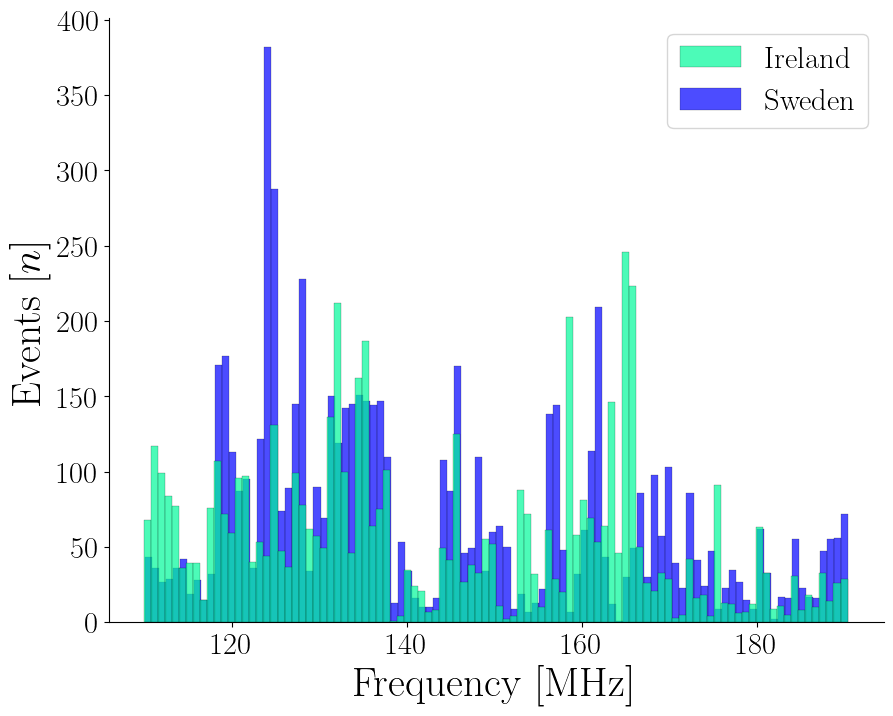

In [4]:
bins_n = 100
# with plt.style.context('dark_background'):
plt.figure(figsize=(10, 8))
plt.hist(ie_data[1], bins = bins_n, density = False, facecolor='mediumspringgreen', alpha=0.7, edgecolor ="black", linewidth=0.2, label = 'Ireland', zorder = 3)
plt.hist(se_data[1], bins = bins_n, density = False, facecolor='blue', alpha=0.7, edgecolor ="black", linewidth=0.2, label ='Sweden', zorder = 2)
plt.xlabel('Frequency [MHz]'); plt.ylabel('Events [$n$]')
plt.legend()

/var/folders/9k/zxw1zx552m142q6419p6yn7c0000gn/T/ipykernel_43703/3340857875.py:8: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,8))


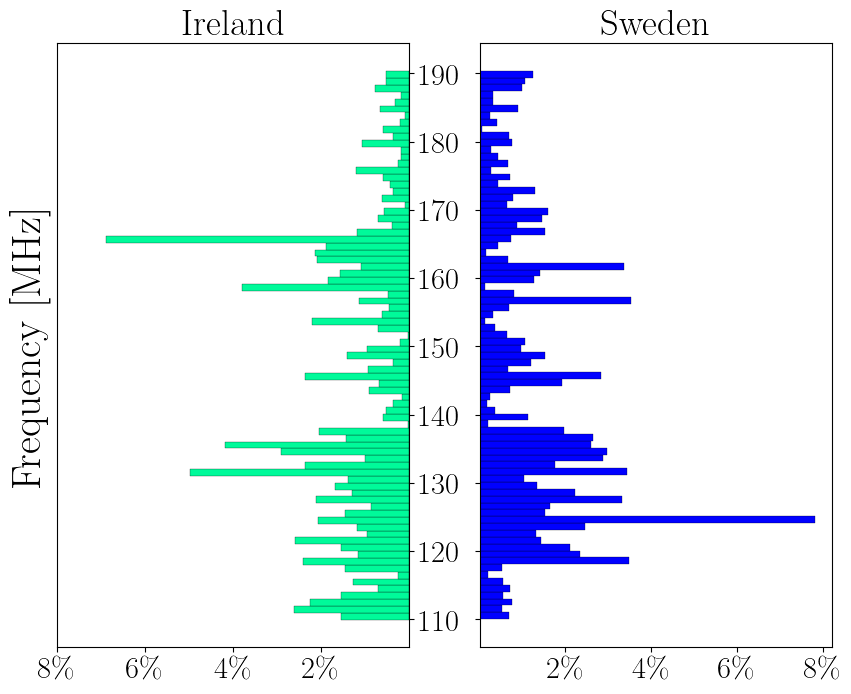

In [56]:

from matplotlib.ticker import PercentFormatter

# with plt.style.context('dark_background'):
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

# with plt.style.context('dark_background'):
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,8))

bins_n = 80

ax1.hist(ie_data[1], bins = bins_n, orientation=u'horizontal', weights=np.ones(len(ie_data[1])) / len(ie_data[1]), facecolor = 'mediumspringgreen',  edgecolor ="black", linewidth=0.2)
ax1.set_ylabel('Frequency [MHz]'); ax1.set_title('Ireland')
ax1.invert_xaxis(); ax1.yaxis.tick_right()
ax1.set_xticks(np.arange(0, 0.1, step=0.02))
ax1.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax1.set_xticks(np.arange(0.02, 0.1, step=0.02))


ax2.hist(se_data[1], bins = bins_n, orientation=u'horizontal', weights=np.ones(len(se_data[1])) / len(se_data[1]), facecolor = 'blue',  edgecolor ="black", linewidth=0.2)
ax2.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax2.set_title('Sweden')
ax2.set_xticks(np.arange(0.02, 0.1, step=0.02))

plt.savefig('hits_comparative_histogram.pdf', bbox_inches='tight')

# SNR Histograms 

Max S/N, Ireland: 10569934.190535 
Max S/N Sweden: 469236.96875


/var/folders/9k/zxw1zx552m142q6419p6yn7c0000gn/T/ipykernel_32108/1061406073.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(ie_data[2], bins, facecolor='mediumspringgreen', alpha=0.7, edgecolor ="black", linewidth=0.2, label = 'Ireland', zorder = 3)


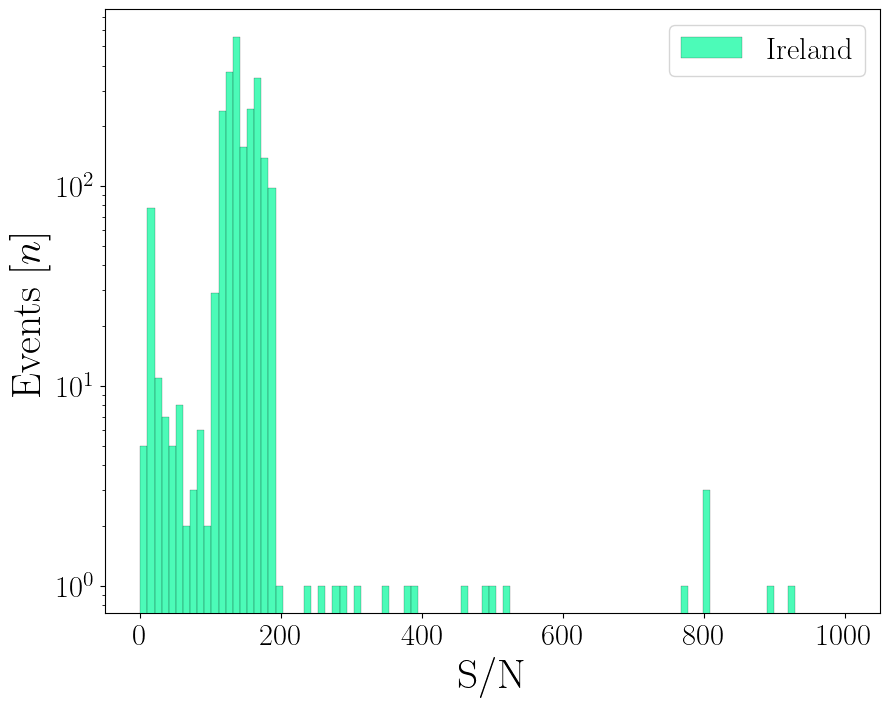

In [30]:


print('Max S/N, Ireland:', ie_data[2].max(), '\nMax S/N Sweden:', se_data[2].max())

bins = bins = np.linspace(0, 10**3, 100)

plt.figure(figsize=(10, 8))
plt.hist(ie_data[2], bins, facecolor='mediumspringgreen', alpha=0.7, edgecolor ="black", linewidth=0.2, label = 'Ireland', zorder = 3)
# plt.hist(se_data[2], bins, facecolor='blue', alpha=0.7, edgecolor ="black", linewidth=0.2, label ='Sweden', zorder = 2)
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('S/N'); plt.ylabel('Events [$n$]')
plt.legend()
plt.show() 

/var/folders/9k/zxw1zx552m142q6419p6yn7c0000gn/T/ipykernel_43703/1150148928.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,8))


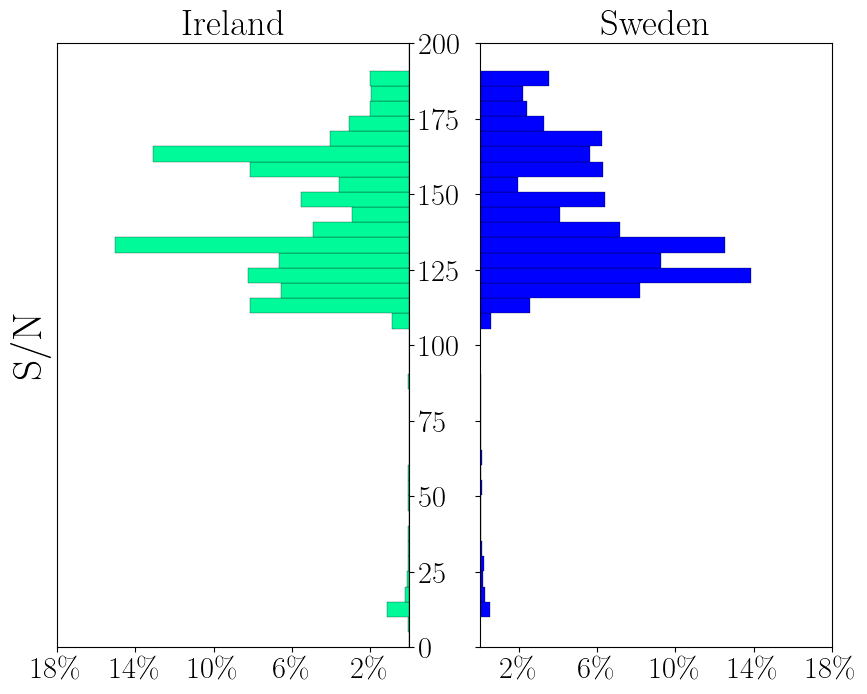

In [22]:

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

# with plt.style.context('dark_background'):
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,8))

bins = np.linspace(0, 10**3, 200)

ax2.yaxis.set_label_coords(-.1, .5)
ax1.hist(ie_data[2], bins, orientation=u'horizontal', weights=np.ones(len(ie_data[2])) / len(ie_data[2]), facecolor = 'mediumspringgreen',  edgecolor ="black", linewidth=0.2)
ax1.set_ylabel('S/N'); ax1.set_title('Ireland')
ax1.invert_xaxis(); ax1.yaxis.tick_right()
ax1.set_xticks(np.arange(0.02, 0.19, step=0.04))
ax1.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))


ax2.hist(se_data[2], bins, orientation=u'horizontal', weights=np.ones(len(se_data[2])) / len(se_data[2]), facecolor = 'blue',  edgecolor ="black", linewidth=0.2)
ax2.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax2.set_title('Sweden')
ax2.set_ylim(0, 200)
ax2.set_xticks(np.arange(0.02, 0.19, step=0.04))


plt.savefig('SN_comparative_histogram.pdf', bbox_inches='tight')

# Drift Rate Histogram 

Max S/N, Ireland: 10569934.190535 
Max S/N Sweden: 469236.96875


/var/folders/9k/zxw1zx552m142q6419p6yn7c0000gn/T/ipykernel_32108/963429452.py:7: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(ie_data[3], bins = bins_n, density = False, facecolor='mediumspringgreen', alpha=0.7, edgecolor ="black", linewidth=0.2, label = 'Ireland', zorder = 3)


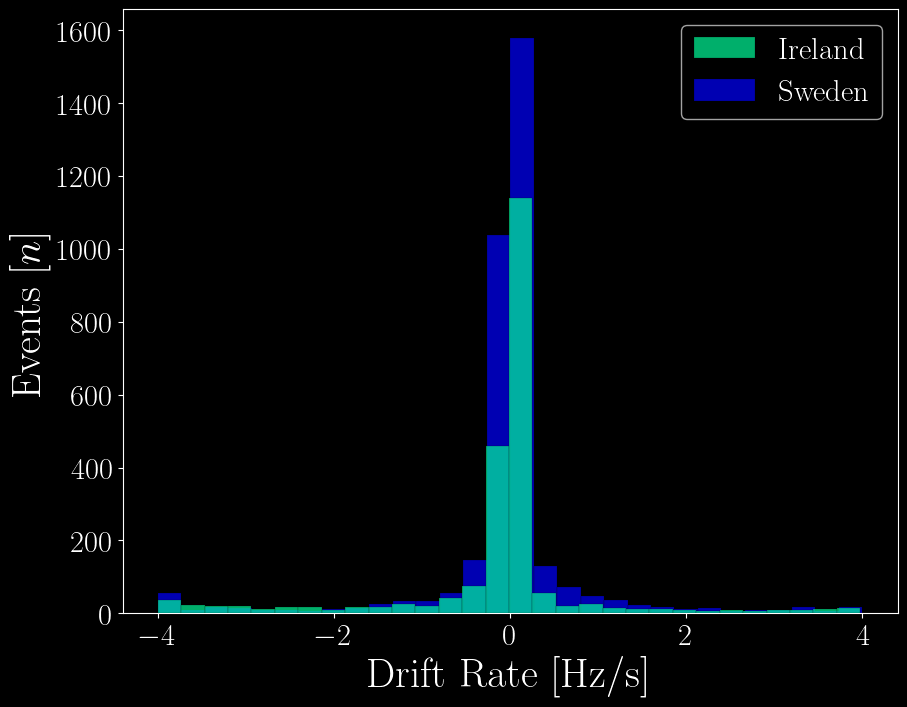

In [9]:
bins_n = 30

print('Max S/N, Ireland:', ie_data[2].max(), '\nMax S/N Sweden:', se_data[2].max())

with plt.style.context('dark_background'):
    plt.figure(figsize=(10, 8))
    plt.hist(ie_data[3], bins = bins_n, density = False, facecolor='mediumspringgreen', alpha=0.7, edgecolor ="black", linewidth=0.2, label = 'Ireland', zorder = 3)
    plt.hist(se_data[3], bins = bins_n, density = False, facecolor='blue', alpha=0.7, edgecolor ="black", linewidth=0.2, label ='Sweden', zorder = 2)
    plt.xlabel('Drift Rate [Hz/s]'); plt.ylabel('Events [$n$]')
    plt.legend()

/var/folders/9k/zxw1zx552m142q6419p6yn7c0000gn/T/ipykernel_43703/578429758.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,8))


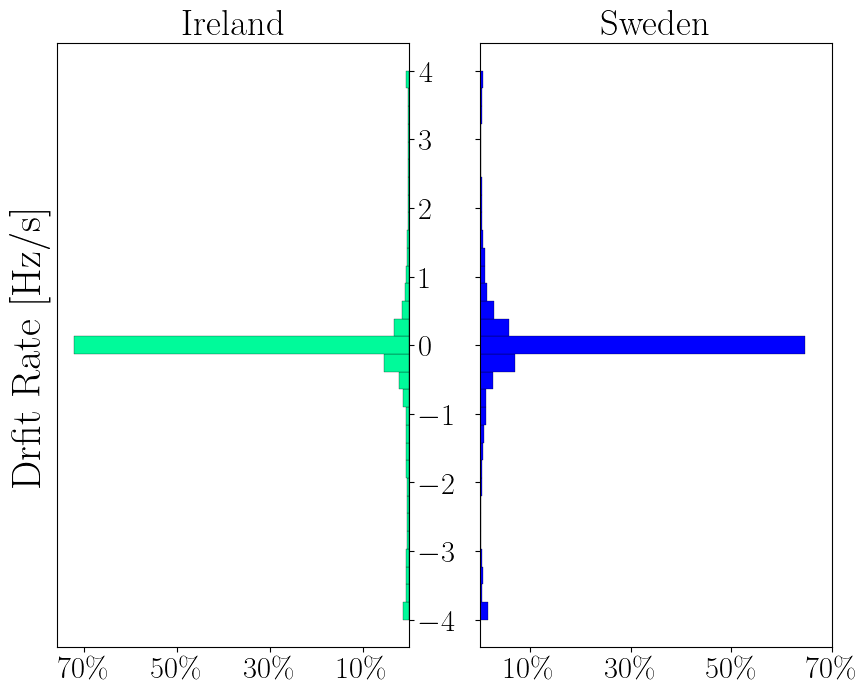

In [48]:

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

# with plt.style.context('dark_background'):
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,8))

bins = np.linspace(-4, 4, 32)

ax2.yaxis.set_label_coords(-.1, .5)
ax1.hist(ie_data[3], bins, orientation=u'horizontal', weights=np.ones(len(ie_data[3])) / len(ie_data[3]), facecolor = 'mediumspringgreen',  edgecolor ="black", linewidth=0.2)
ax1.set_ylabel('Drfit Rate [Hz/s]'); ax1.set_title('Ireland')
ax1.invert_xaxis(); ax1.yaxis.tick_right()
ax1.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax1.set_xticks(np.arange(0.1, 0.8, step=0.2))


ax2.hist(se_data[3], bins, orientation=u'horizontal', weights=np.ones(len(se_data[3])) / len(se_data[3]), facecolor = 'blue',  edgecolor ="black", linewidth=0.2)
ax2.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax2.set_title('Sweden')
# ax2.set_ylim(0, 200)
ax2.set_xticks(np.arange(0.1, 0.8, step=0.2))


plt.savefig('DR_comparative_histogram.pdf', bbox_inches='tight')

# Drift Rate vs. Frequency 

/var/folders/9k/zxw1zx552m142q6419p6yn7c0000gn/T/ipykernel_43703/1662468126.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(ie_data[1], ie_data[3], facecolor = 'green', edgecolors='None', s = 5, alpha = 0.5, zorder = 3, label = 'Ireland')


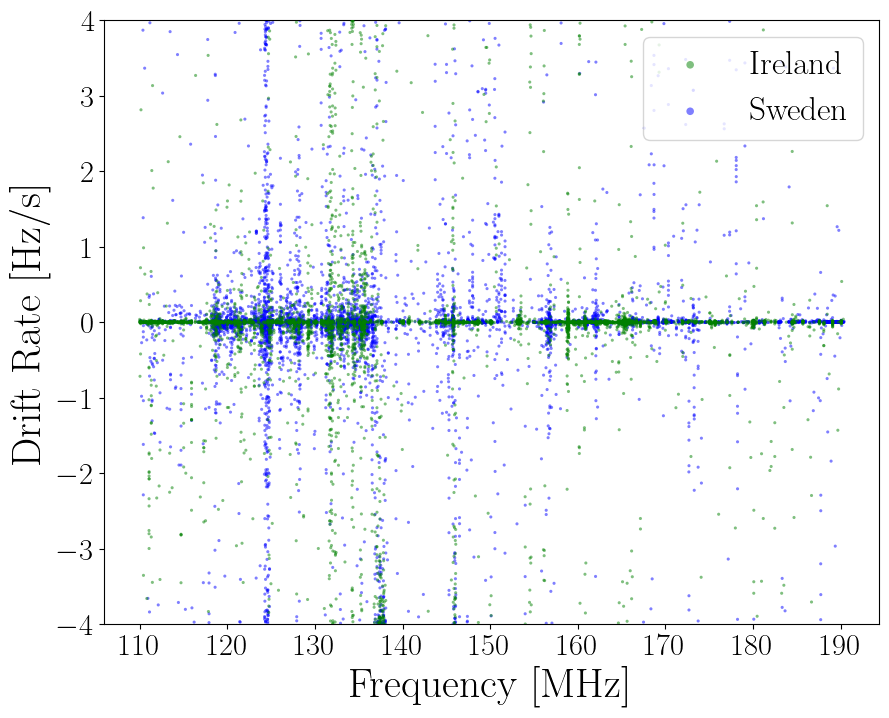

In [59]:
# with plt.style.context('dark_background'):
plt.figure(figsize=(10, 8))

plt.scatter(ie_data[1], ie_data[3], facecolor = 'green', edgecolors='None', s = 5, alpha = 0.5, zorder = 3, label = 'Ireland')
plt.scatter(se_data[1], se_data[3], facecolor = 'blue', edgecolors='None', s = 5, alpha = 0.5, label = 'Sweden')
plt.xticks(np.arange(110, 200, step=10))

plt.ylabel('Drift Rate [Hz/s]'); plt.xlabel('Frequency [MHz]')
plt.ylim(-4, 4)

lgnd = plt.legend(loc=1, scatterpoints=1, fontsize=24)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

plt.savefig('DR_scatter_plot.pdf', bbox_inches='tight')